# Notebook to generate sankey plot

In [24]:
import openai
import os
from textwrap import dedent
import pandas as pd
import pickle
import numpy as np
import matplotlib.font_manager as fm
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from pysankey2.utils import setColorConf
from pysankey2 import Sankey
from pysankey2.datasets import load_countrys

In [2]:
def get_shortest_path(source_node, target_node):
    try:
        shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight="weight", method="dijkstra")
        weighted_distance = nx.shortest_path_length(G, source=source_node, target=target_node, weight="weight", method="dijkstra")
        return(shortest_path, weighted_distance)
    except nx.NetworkXNoPath:
        return(None)

**Data loading**  
the data starts with the mean similarity (pickled) file  an similarity (pickled) file  

In [3]:
mean_similarity_df = pd.read_pickle("../../data/similarity_df_mean.pkl")
words = mean_similarity_df.columns
upper_triangle = np.triu(mean_similarity_df, k=1)
upper_tri_sim = mean_similarity_df.values[np.triu_indices(mean_similarity_df.shape[0], k=1)]
upper_triangle[upper_triangle < np.percentile(upper_tri_sim, q=50)] = 0
upper_triangle = np.where(upper_triangle > 0, 1 - upper_triangle, upper_triangle)

In [5]:
G = nx.Graph(upper_triangle)
node_labels = {i:word for i, word in enumerate(words)}
G = nx.relabel_nodes(G, node_labels)
num_nodes = len(G.nodes())
num_edges = len(G.edges())

In [6]:
tokens_all = ", ".join(mean_similarity_df.columns)
tokens_sub = ", ".join(mean_similarity_df.columns[:1000])

#### shortest word paths to racism

In [40]:
# example
(get_shortest_path("hardship", "racism"))

(['hardship', 'neglect', 'inferiority', 'overt', 'prejudice', 'racism'],
 0.29601932366689043)

In [ ]:
%%time
# code that was used to save
shortestpath2racism = [(get_shortest_path(term, "racism")) for term in tqdm(related_terms)]

# GPT for data curation

## Query chat GPT

In [6]:
# Set up OpenAI API key
api_path = os.path.join(os.environ['HOME'], 'openai.txt')
with open(api_path, 'r') as f:
    openai.api_key = f.read().strip()

In [7]:
system = dedent("""
    You are a tool for labeling health related terms. 
    You will be given a list of health related terms with each term separated by a comma.
    Please return the words from the given list that is related or contributing to health disparities.
    Return "poverty", "homophobia", "stigma", "stress", and "racism" because they are directly related and contributing to health disparities.
    Do not return "africa", "male", "health", "patient", "black", "cocaine", "invasion", "horrible", and "cancer" because they are not directly contributing to health disparities.
    If none of the terms are health related terms, return "NONE".
    """)
# comment = "health, poverty, cancer, stress, doctor"
# comment = tokens_sub

input_ex = 'care, medical, homophobia, black, poverty, population, service, woman, many, study, system, doctor, need, public, data, year, time, research, may, risk, would, racism, individual, policy'
desired_output = 'homophobia, poverty, racism'

In [8]:
def run_gpt(system, comment, example1, output1):
    response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[
                   {"role": "system", "content": system},
                   {"role": "user", "content": example1},
                   {"role": "assistant", "content": output1},
                   {"role": "user", "content": comment}
                ],
                temperature=0.4) 
    return(response['choices'][0]['message']['content'])

## Run GPT

In [ ]:
run_gpt(system, ", ".join(mean_similarity_df.columns[:1000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[1000:2000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[2000:3000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[3000:4000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[4000:5000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[5000:6000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[6000:7000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[7000:8000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[8000:9000]), input_ex, desired_output)
run_gpt(system, ", ".join(mean_similarity_df.columns[9001:]), input_ex, desired_output)

### Collect results

In [17]:
f1 = 'poverty, stress, stigma, discrimination, inequality, socioeconomic, structural_racism, institutional_racism, racial_ethnic, social_determinant, racial_discrimination, '
f2 = 'implicit_bias, unemployment, uninsured, developing_country, micro_aggression, coronavirus, unconscious_bias, sexism, gender_equality, anti_racism, anti_racist, ageism, distress, '
f3 = 'rural_area, systemic_racism, mass_incarceration, sanitation, race_relation, food_security, mental_disorder, communicable_disease, insurance_coverage, undocumented_migrant, police_violence, root_cause, refugee_asylum_seeker, sexual_harassment, indigenous_australian, hiv_epidemic, literacy, substance_use_disorder, distrust, uninsured, racial_harassment, sexual_orientation, malnutrition, infant_mortality_rate, homeless, xenophobia, '
f4 = 'homophobia, depression_anxiety, working_class, educational_attainment, environmental_injustice, water_pollution, police_brutality, language_barrier, diversity_inclusion, intolerance, colonialism, social_distancing, genocide, racism_sexism, hunger, institutionalized_racism, substance_abuse, bullying_harassment, stereotype_threat, family_planning, race_conscious, contraception, intimate_partner_violence, residential_segregation, pregnant, '
f5 = 'homelessness, psychological_distress, stress, stigmatization, urbanization, extreme_poverty, stressful, anxious, '
f6 = 'hardship, victimization, loneliness, '
f7 = 'financial_hardship, physical_inactivity, oppressive, racially_motivated, obesity, antisemitism, patriarchy, eviction, deleterious, sedentary, burdensome, burnout, inaccessible, '
f8 = 'famine, stigmatize, disenfranchised, exploitative, stratification, elitism, heroin, tuberculosis_malaria, jim_crow, brutality, alcoholic, homophobic, disenfranchisement'

related_terms = f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8
related_terms = related_terms.split(", ")
print(len(related_terms))
related_terms = list(set(related_terms))
print(len(related_terms))

112
110


In [ ]:
%%time
shortestpath2racism = [(get_shortest_path(term, "racism")) for term in tqdm(related_terms)]

In [10]:
file_path = '../../data/shortestpath2racism_2.pickle'
shortestpath2racism2 = pd.read_pickle(file_path)
none_count = shortestpath2racism2.count(None)
shortestpath2racism22 = [word_list for word_list in shortestpath2racism2 if word_list is not None]

# Analyzing the term set

In [27]:
layers = list(zip(*[x[-3:] for x in shortestpath2racism22 if len(x) != 2] + [[np.nan, 'discrimination', 'racism']]))
flattened_list = sum([x[-3:] for x in shortestpath2racism2], [])
# Convert tuples to lists
third_layer = list(layers[0])
second_layer = list(layers[1])
first_layer = list(layers[2])

In [28]:
df = pd.DataFrame({'layer1':first_layer, 'layer2':second_layer, 'layer3':third_layer})

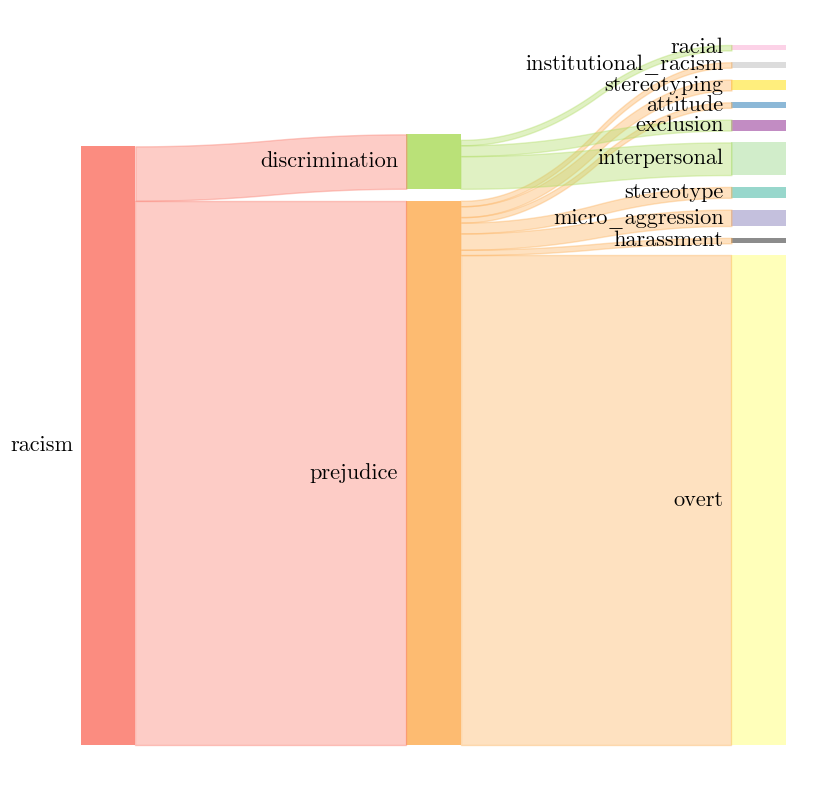

In [39]:
colors = setColorConf(len(set(flattened_list)),colors='Set3')
cls_map = dict(zip(list(set(flattened_list)),colors))

# set stripColor="left" 
sky = Sankey(df,colorDict=cls_map,colorMode="global",stripColor='left')
font = fm.FontProperties(fname='../../../font/cmunrm.ttf')
fig,ax = sky.plot()

for text in ax.texts:
    text.set_fontproperties(font)
    text.set_fontsize(16)


plt.savefig('../../results/figures/sankey_diagram.png', dpi=300, bbox_inches='tight')